In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
data=pd.read_csv("/home/hjkim/sungkenh/data/yield_tomato.csv")
data

,yield
0,2
1,14
2,38
3,41
4,51
5,82
6,99
7,96
8,105
9,96


In [3]:
data['yield'].mean()

77.19444444444444

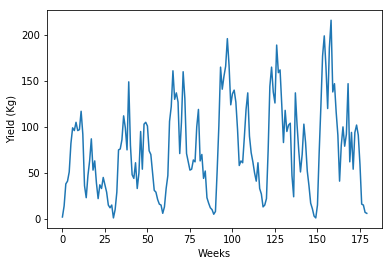

In [5]:
plt.plot(data['yield'])
plt.ylabel('Yield (Kg)')
plt.xlabel('Weeks')
plt.show()

In [7]:
from numpy import split
from numpy import array

def split_dataset(data):
    # split into standard weeks
    train, test = data[0:144], data[144:180]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/4))
    test = array(split(test, len(test)/4))
    return train, test

In [8]:
train, test=split_dataset(data.values)

In [9]:
train.shape, test.shape

((36, 4, 1), (9, 4, 1))

In [10]:
def to_supervised(train, n_input, n_out=1):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [11]:
train_x, train_y=to_supervised(train,4)
print(train_x.shape, train_y.shape)
#train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

(140, 4, 1) (140, 1)


In [12]:
test_x, test_y=to_supervised(test,4)
print(test_x.shape, test_y.shape)
#test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

(32, 4, 1) (32, 1)


In [14]:
from keras.layers import LSTM 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, InputLayer, MaxPooling1D, Flatten, RepeatVector, TimeDistributed, Embedding, Input, UpSampling1D
import keras.backend as K 

verbose, epochs, batch_size= 1, 200, 64
n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
K.clear_session() 
input_layer = Input(batch_shape=(None,n_timesteps,n_features))
encoder = Conv1D(4,4,activation="relu",padding="same")(input_layer)
#encoder = MaxPooling1D(2)(encoder)
encoder = Conv1D(2,2,activation="relu",padding="same")(encoder)
encoder = MaxPooling1D(2)(encoder)
encoder = LSTM(12, activation='relu', return_sequences=True)(encoder)

latent = Conv1D(1,3, activation='relu', padding='same')(encoder)

decoder = LSTM(12, activation='relu', return_sequences=True)(latent)
decoder = Conv1D(2,2,activation="relu",padding="same")(decoder)
#decoder = UpSampling1D(2)(decoder)
decoder = Conv1D(4,4,activation="relu",padding="same")(decoder)
decoder = UpSampling1D(2)(decoder)
output = Conv1D(1, 3,activation='relu', padding='same')(decoder)

autoencoder = Model(input_layer, output)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 4)              20        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 2)              18        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 12)             720       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 1)              37        
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 12)             672       
__________

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')
history = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(test_x, test_x)).history

Train on 140 samples, validate on 32 samples
Epoch 1/200


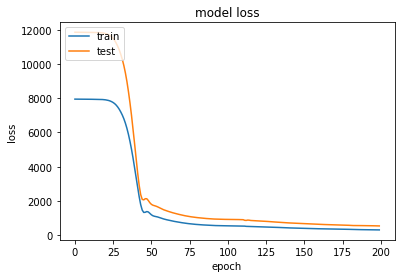

In [1595]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1596]:
latent_train = Model(input_layer,latent)
embe_vec=latent_train.predict(train_x)
print(embe_vec.shape)

(140, 2, 1)


In [1597]:
latent_test = Model(input_layer,latent)
test_vec=latent_test.predict(test_x)
print(test_vec.shape)

(32, 2, 1)


In [1602]:
from keras.layers import LSTM 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, InputLayer, MaxPooling1D, Flatten, RepeatVector, TimeDistributed, Embedding, Input, Dropout
import keras.backend as K 
from keras.callbacks import EarlyStopping 
verbose, epochs, batch_size = 1, 500, 64
n_timesteps, n_features = embe_vec.shape[1], embe_vec.shape[2]
model = Sequential()
model.add(Conv1D(2,2,activation="relu",padding="same", input_shape=(n_timesteps,n_features)))
#model.add(Dropout(0.2))
model.add(Conv1D(1,1,activation="relu",padding="same"))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(RepeatVector(4))
model.add(LSTM(12, activation='relu'))
model.add(Dense(6))
model.add(Dense(1))
model.summary()
model.compile(loss='mse', optimizer='adam') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 2, 2)              6         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2, 1)              3         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 1)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1)                 0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 1)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 12)                672       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 78        
__________

In [1615]:
history = model.fit(embe_vec, train_y,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=verbose,                
                    validation_data=(test_vec, test_y)).history

Train on 140 samples, validate on 32 samples
Epoch 1/500
140/140 [==============================] - 0s 466us/step - loss: 827.9221 - val_loss: 2445.2756
Epoch 2/500
140/140 [==============================] - 0s 433us/step - loss: 832.8197 - val_loss: 2418.1567
Epoch 3/500
140/140 [==============================] - 0s 395us/step - loss: 817.1931 - val_loss: 2354.1589
Epoch 4/500
140/140 [==============================] - 0s 387us/step - loss: 800.8701 - val_loss: 2302.7825
Epoch 5/500
140/140 [==============================] - 0s 428us/step - loss: 803.0939 - val_loss: 2256.9302
Epoch 6/500
140/140 [==============================] - 0s 439us/step - loss: 804.8627 - val_loss: 2240.9207
Epoch 7/500
140/140 [==============================] - 0s 408us/step - loss: 807.1590 - val_loss: 2226.0652
Epoch 8/500
140/140 [==============================] - 0s 410us/step - loss: 807.5177 - val_loss: 2230.5901
Epoch 9/500
140/140 [==============================] - 0s 433us/step - loss: 804.0420 - val

Epoch 76/500
140/140 [==============================] - 0s 421us/step - loss: 800.2593 - val_loss: 2302.0952
Epoch 77/500
140/140 [==============================] - 0s 403us/step - loss: 799.3341 - val_loss: 2307.4072
Epoch 78/500
140/140 [==============================] - 0s 439us/step - loss: 801.0712 - val_loss: 2309.1025
Epoch 79/500
140/140 [==============================] - 0s 443us/step - loss: 798.3952 - val_loss: 2292.4131
Epoch 80/500
140/140 [==============================] - 0s 418us/step - loss: 797.4796 - val_loss: 2269.4370
Epoch 81/500
140/140 [==============================] - 0s 406us/step - loss: 797.9415 - val_loss: 2252.5234
Epoch 82/500
140/140 [==============================] - 0s 375us/step - loss: 798.3015 - val_loss: 2236.6738
Epoch 83/500
140/140 [==============================] - 0s 427us/step - loss: 801.7399 - val_loss: 2222.8679
Epoch 84/500
140/140 [==============================] - 0s 415us/step - loss: 807.1230 - val_loss: 2214.9917
Epoch 85/500
140/14

140/140 [==============================] - 0s 443us/step - loss: 793.2482 - val_loss: 2436.4412
Epoch 225/500
140/140 [==============================] - 0s 438us/step - loss: 793.5631 - val_loss: 2415.2207
Epoch 226/500
140/140 [==============================] - 0s 403us/step - loss: 791.6454 - val_loss: 2374.5605
Epoch 227/500
140/140 [==============================] - 0s 434us/step - loss: 790.4122 - val_loss: 2357.2498
Epoch 228/500
140/140 [==============================] - 0s 454us/step - loss: 787.7681 - val_loss: 2345.5984
Epoch 229/500
140/140 [==============================] - 0s 418us/step - loss: 787.9240 - val_loss: 2333.8606
Epoch 230/500
140/140 [==============================] - 0s 365us/step - loss: 787.3374 - val_loss: 2317.4871
Epoch 231/500
140/140 [==============================] - 0s 399us/step - loss: 785.4421 - val_loss: 2321.0259
Epoch 232/500
140/140 [==============================] - 0s 423us/step - loss: 787.0436 - val_loss: 2324.6506
Epoch 233/500
140/140 [=

140/140 [==============================] - 0s 382us/step - loss: 780.9272 - val_loss: 2238.6528
Epoch 373/500
140/140 [==============================] - 0s 385us/step - loss: 780.5452 - val_loss: 2236.9688
Epoch 374/500
140/140 [==============================] - 0s 415us/step - loss: 780.7316 - val_loss: 2227.6030
Epoch 375/500
140/140 [==============================] - 0s 430us/step - loss: 785.3877 - val_loss: 2232.3369
Epoch 376/500
140/140 [==============================] - 0s 411us/step - loss: 780.2212 - val_loss: 2261.1514
Epoch 377/500
140/140 [==============================] - 0s 362us/step - loss: 781.9360 - val_loss: 2277.7312
Epoch 378/500
140/140 [==============================] - 0s 392us/step - loss: 796.5230 - val_loss: 2262.8901
Epoch 379/500
140/140 [==============================] - 0s 377us/step - loss: 795.0211 - val_loss: 2219.8682
Epoch 380/500
140/140 [==============================] - 0s 399us/step - loss: 783.6728 - val_loss: 2197.1704
Epoch 381/500
140/140 [=

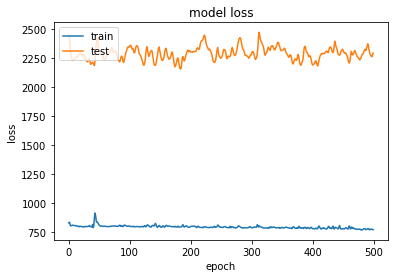

In [1616]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1617]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

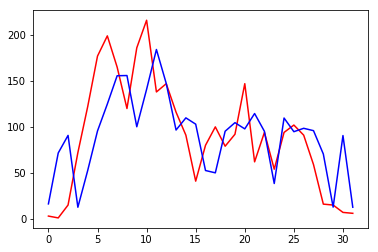

47.8557764889528 38.61876395344734 331.0587410783515


In [1618]:
y_pred=model.predict(test_vec)
actual_y = []
for i in range(len(test_y)):
    actual_y.append(test_y[i][0])
y_hat = []
for i in range(len(y_pred)):
    y_hat.append(y_pred[i][0])
plt.plot(actual_y,'r')
plt.plot(y_hat,'b')
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

mse=mean_squared_error(actual_y,y_hat)
rmse=sqrt(mse)
mae=mean_absolute_error(actual_y,y_hat)
mape=mean_absolute_percentage_error(actual_y, y_hat)
print(rmse,mae, mape)

In [6]:
y_pred=model.predict(embe_vec)
actual_y = []
for i in range(len(train_y)):
    actual_y.append(train_y[i][0])
y_hat = []
for i in range(len(y_pred)):
    y_hat.append(y_pred[i][0])
plt.plot(actual_y,'r', linestyle='solid')
plt.plot(y_hat,'b', linestyle='dashdot')
plt.ylabel('Yield (Kg)')
plt.xlabel('Weeks')
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

mse=mean_squared_error(actual_y,y_hat)
rmse=sqrt(mse)
mae=mean_absolute_error(actual_y,y_hat)
r2 = r2_score(actual_y,y_hat)
#mape=mean_absolute_percentage_error(actual_y, y_hat)
print(rmse,mae, r2)

NameError: name 'model' is not defined

In [1280]:
from keras.layers import LSTM 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, InputLayer, MaxPooling1D, Flatten, RepeatVector, TimeDistributed, Embedding, Input
import keras.backend as K 
from keras.callbacks import EarlyStopping 
verbose, epochs, batch_size = 1, 400, 64
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

input_layer = Input(batch_shape=(None ,n_timesteps,n_features))
conv = Conv1D(12,12,activation="relu",padding="same")(input_layer)
conv = MaxPooling1D(2)(conv)
conv = Conv1D(4,4,activation="relu",padding="same")(conv)
conv = MaxPooling1D(2)(conv)
conv = Flatten()(conv)
conv = RepeatVector(n_outputs)(conv)
lstm = LSTM(12, activation='relu', return_sequences=True)(input_layer)
lstm = TimeDistributed(Dense(6, activation='relu'))(lstm)
output = TimeDistributed(Dense(1))(lstm)
cnn_lstm = Model(input_layer, output)
cnn_lstm.summary()
cnn_lstm.compile(loss='mse', optimizer='adam') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 12)            672       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 12, 6)             78        
_________________________________________________________________
time_distributed_8 (TimeDist (None, 12, 1)             7         
Total params: 757
Trainable params: 757
Non-trainable params: 0
_________________________________________________________________


In [1281]:
test_x, test_y=to_supervised(test,12)
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

In [1282]:
print(test_x.shape, test_y.shape)

(24, 12, 1) (24, 1, 1)


In [1283]:
history = cnn_lstm.fit(train_x, train_y,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=verbose,                
                    validation_data=(test_x, test_y)).history

ValueError: Error when checking target: expected time_distributed_8 to have shape (12, 1) but got array with shape (1, 1)

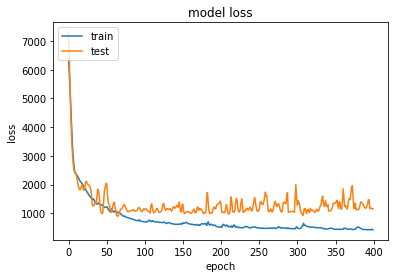

In [1276]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

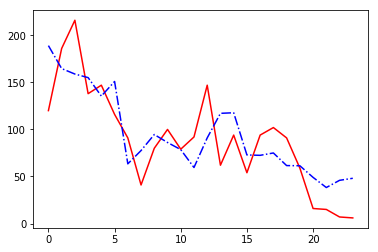

34.011991920015525 29.498396237691242 0.5822448175374476


In [1277]:
y_pred=cnn_lstm.predict(test_x)
actual_y = []
for i in range(len(test_y)):
    actual_y.append(test_y[i][0][0])
y_hat = []
for i in range(len(y_pred)):
    y_hat.append(y_pred[i][0][0])
plt.plot(actual_y,'r', linestyle='solid')
plt.plot(y_hat,'b', linestyle='dashdot')
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

mse=mean_squared_error(actual_y,y_hat)
rmse=sqrt(mse)
mae=mean_absolute_error(actual_y,y_hat)
r2 = r2_score(actual_y,y_hat)
#mape=mean_absolute_percentage_error(actual_y, y_hat)
print(rmse,mae, r2)

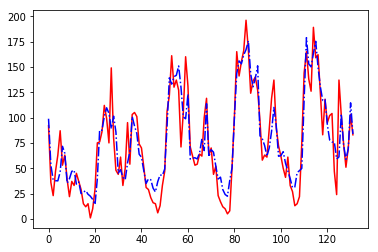

20.397333061455353 15.478198239297578 0.812822035327768


In [1278]:
y_pred=cnn_lstm.predict(train_x)
actual_y = []
for i in range(len(train_y)):
    actual_y.append(train_y[i][0][0])
y_hat = []
for i in range(len(y_pred)):
    y_hat.append(y_pred[i][0][0])
plt.plot(actual_y,'r', linestyle='solid')
plt.plot(y_hat,'b', linestyle='dashdot')
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

mse=mean_squared_error(actual_y,y_hat)
rmse=sqrt(mse)
mae=mean_absolute_error(actual_y,y_hat)
r2 = r2_score(actual_y,y_hat)
#mape=mean_absolute_percentage_error(actual_y, y_hat)
print(rmse,mae, r2)